# EoR Signal Separation with Polynomial Fitting Method

---

### Weitian LI

* https://github.com/liweitianux/cdae-eor

---

## Introduction

The **polynomial fitting** is a common traditional method to uncover the faint EoR signal.
It fits a low-degree polynomial for each sky pixel along the frequency dimension (i.e., line-of-sight),
and then subtract the fitted smooth component, which is regarded as the foreground emission,
to uncover the EoR signal.

Traditional foreground removal methods, such as the polynomial fitting method, assume that
foreground spectra must be very smooth, which is distinct from the EoR signal.
However, the complicated instrumental effects, such as the frequency-dependent beam effects,
can destroy the smoothness of foreground spectra, preventing such methods from removing the foreground.

---

## 1. Import packages and basic settings

In [1]:
import os
from os import path

import numpy as np
from astropy.io import fits

# Credit: https://stackoverflow.com/a/20203966
from numpy.polynomial.polynomial import polyfit, polyval

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
mpl.style.use("ggplot")
for k, v in [("font.family",       "Inconsolata"),
             ("font.size",         14.0),
             ("pdf.fonttype",      42),  # Type 42 (a.k.a. TrueType)
             ("figure.figsize",    [8, 6]),
             ("image.cmap",        "jet"),
             ("xtick.labelsize",   "large"),
             ("xtick.major.size",  7.0),
             ("xtick.major.width", 2.0),
             ("xtick.minor.size",  4.0),
             ("xtick.minor.width", 1.5),
             ("ytick.labelsize",   "large"),
             ("ytick.major.size",  7.0),
             ("ytick.major.width", 2.0),
             ("ytick.minor.size",  4.0),
             ("ytick.minor.width", 1.5)]:
    mpl.rcParams[k] = v

---

## 2. Custom functions

In [4]:
def rms(a, axis=None):
    return np.sqrt(np.mean(a**2, axis=axis))

In [5]:
def a_summary(a):
    print('min:', np.min(a))
    print('max:', np.max(a))
    print('mean:', np.mean(a))
    print('std:', np.std(a))
    print('median:', np.median(a))

In [6]:
def plot_cubes(rpix, cubes, show_diff=True):
    nfreq0, ny, nx = cubes[0].shape
    x_ = range(nfreq0)
    ry = rpix // ny
    rx = rpix % ny
    spec = [
        (0, 0, 'EoR', cubes[0], False),
        (0, 1, 'Galactic', cubes[1], show_diff),
        (1, 0, 'Halos', cubes[2], show_diff),
        (1, 1, 'PointSources', cubes[3], show_diff),
    ]
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))

    for (ir, ic, t_, data_, diff_) in spec:
        if data_ is None:
            continue
        ax = axes[ir, ic]
        ax.set_title(t_)
        for ix, iy in zip(rx, ry):
            ax.plot(x_, data_[:, iy, ix] * 1e3, lw=2.5)
        if diff_:
            ax_ = ax.twinx()
            for ix, iy in zip(rx, ry):
                ax_.plot(x_[:-1], np.diff(data_[:, iy, ix]) * 1e3, lw=1, alpha=0.7)

    for (ir, ic) in [(0, 0), (1, 0)]:
        ax = axes[ir, ic]
        ax.set_ylabel('<brightness> [mK]')
    for (ir, ic) in [(1, 0), (1, 1)]:
        ax = axes[ir, ic]
        ax.set_xlabel('<frequency channel>')

    plt.tight_layout()
    plt.show()

In [7]:
# correlation coefficient

def corrcoef(s1, s2):
    # calculate: np.corrcoef(s1, s2)[0, 1]
    m1 = np.mean(s1)
    m2 = np.mean(s2)
    return np.sum((s1-m1) * (s2-m2)) / np.sqrt(np.sum((s1-m1)**2) * np.sum((s2-m2)**2))


def corrcoef_ds(ds1, ds2):
    # shape: [npix, nfreq]
    n = ds1.shape[0]
    cc = np.zeros((n,))
    for i in range(n):
        cc[i] = corrcoef(ds1[i, :], ds2[i, :])
    return cc

In [8]:
def fit_foreground(freqs, data, degree=2):
    # data shape: [nfreq, npix]
    pfit = polyfit(freqs, data, deg=degree)
    return np.swapaxes(polyval(freqs, pfit), 0, 1)

In [9]:
def plot_fitresult(rpix, xfit, xout, xinput, xlabel):
    nfreq, npix = xfit.shape
    freqs = np.linspace(154, 162, nfreq)
    fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 6))

    for i, r in enumerate(rpix):
        ax0.plot(freqs, xfit[:, r], color=f'C{i}', alpha=0.7, lw=2)
        ax0.plot(freqs, xinput[:, r], color=f'C{i}', alpha=0.7, lw=1.5, ls='--')
        ax1.plot(freqs, xout[:, r], color=f'C{i}', alpha=0.7, lw=2)
        ax1.plot(freqs, xlabel[:, r], color=f'C{i}', alpha=0.7, lw=1.5, ls='--')

    plt.tight_layout()
    plt.show()

---

## 3. Load simulated data

In [10]:
# directory to the simulated cubes
datadir = '../data'

cube_eor   = fits.open(path.join(datadir, 'eor.uvcut_b158c80_n360-cube.fits'  ))[0].data
cube_gal   = fits.open(path.join(datadir, 'gal.uvcut_b158c80_n360-cube.fits'  ))[0].data
cube_halos = fits.open(path.join(datadir, 'halos.uvcut_b158c80_n360-cube.fits'))[0].data
cube_ptr   = fits.open(path.join(datadir, 'ptr.uvcut_b158c80_n360-cube.fits'  ))[0].data

In [11]:
cube_fg  = cube_gal + cube_halos + cube_ptr
cube_tot = cube_fg + cube_eor

rms(cube_eor)*1e3, rms(cube_fg)

(1.712712924927473, 6.134431)

In [12]:
nfreq, ny, nx = cube_eor.shape
npix = nx * ny

nfreq, ny, nx, npix

(101, 360, 360, 129600)

In [13]:
np.random.seed(42)

rpix = np.random.randint(0, high=npix, size=3)
ry = rpix // ny
rx = rpix % ny

rpix

array([121958,  15795,    860])

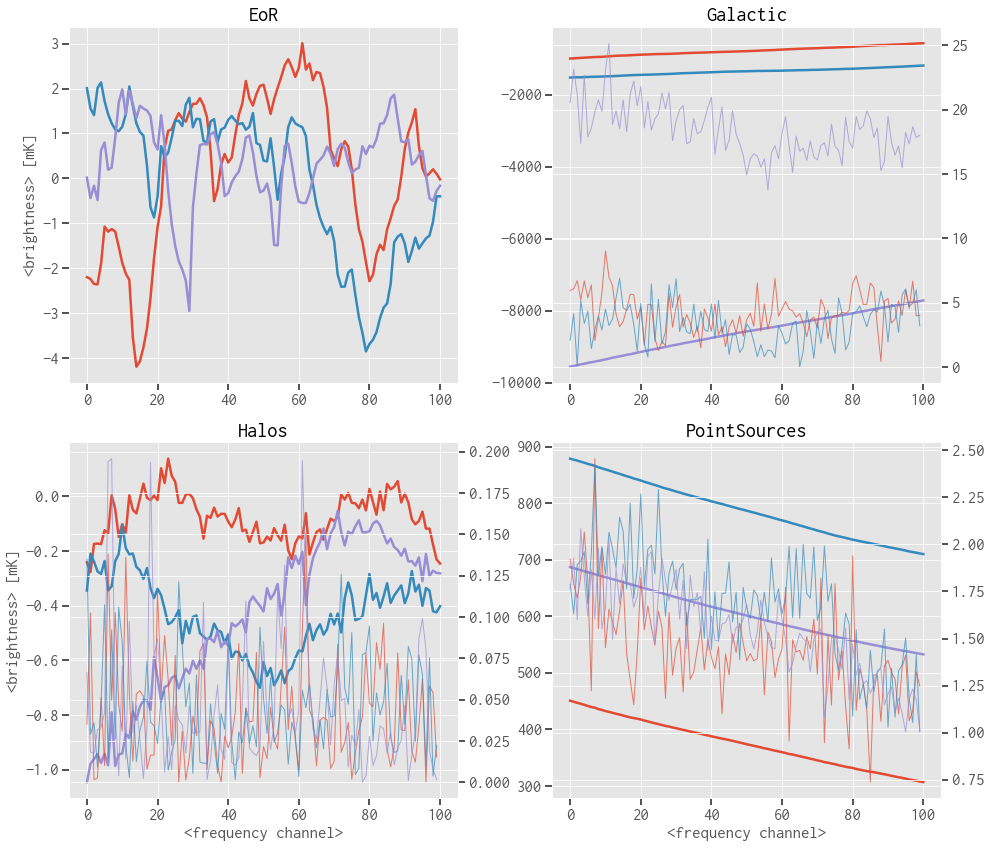

In [14]:
plot_cubes(rpix, (cube_eor, cube_gal, cube_halos, cube_ptr))

---

## 4. Results

In [15]:
freqs = np.linspace(154, 162, nfreq)

x_input = np.array(cube_tot.reshape((nfreq, npix)))
x_input -= np.mean(x_input, axis=0, keepdims=True)
x_input /= np.std(x_input, axis=0, keepdims=True)

x_label = np.array(cube_eor.reshape((nfreq, npix)))
x_label -= np.mean(x_label, axis=0, keepdims=True)
x_label /= np.std(x_label, axis=0, keepdims=True)

In [16]:
degree = 4  # polynomial degree (quartic)
x_fgfit = fit_foreground(freqs, x_input, degree)

# separated EoR signal
x_out = x_input - x_fgfit
x_out -= np.mean(x_out, axis=0, keepdims=True)
x_out /= np.std(x_out, axis=0, keepdims=True)

In [17]:
cc = corrcoef_ds(x_out, x_label)

print('rho: %.4f +/- %.4f' % (cc.mean(), cc.std()))

rho: 0.2411 +/- 0.1033


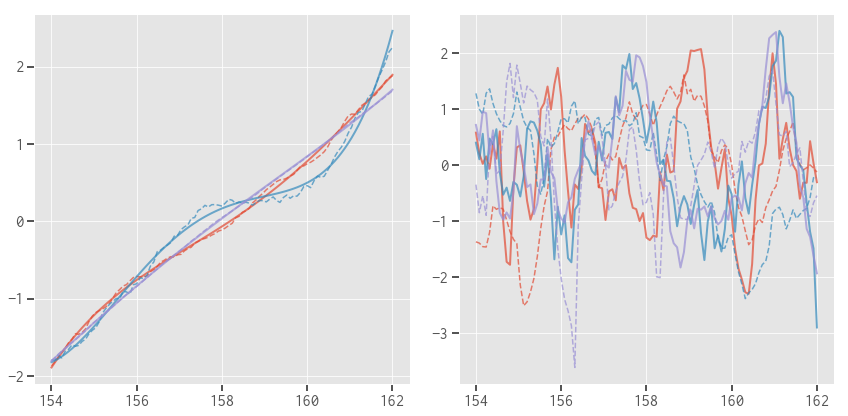

In [18]:
plot_fitresult(rpix, x_fgfit, x_out, x_input, x_label)